In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv("tesla_formatted.csv")

# Moving average agent

The code is implementing a moving average crossover trading strategy by analyzing two moving averages of the asset’s closing prices:
1. Short-term moving average (short_ma): Averages prices over a shorter window.
2.  Long-term moving average (long_ma): Averages prices over a longer window.

It generates signals (1.0 to buy, 0.0 to hold or sell) based on the relationship between these two averages:

- If the short-term moving average is greater than the long-term moving average, a buy signal is generated.
- Otherwise, the signal remains neutral (or a "sell" depending on your trading logic).

In the end some montecarlo simulations for the agent.

In [23]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals.loc[short_window:, 'signal'] = np.where(
    signals.loc[short_window:, 'short_ma'] > signals.loc[short_window:, 'long_ma'], 1.0, 0.0
)
, 0.0)   
signals['positions'] = signals['signal'].diff()

signals.head()

,signal,short_ma,long_ma,positions
0,0.0,20.102667,20.102667,NaN
1,0.0,20.190667,20.190667,0.0
2,0.0,19.664445,19.664445,0.0
3,0.0,19.044667,19.044667,0.0
4,0.0,18.784134,18.784134,0.0


`short_window`: The window size for the short-term moving average is set to 2.5% of the dataset length.
`long_window`: The window size for the long-term moving average is set to 5% of the dataset length.
These percentages define how sensitive the strategy is to price changes. Smaller windows respond faster to price movements.

In [24]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 20,
    max_sell = 20,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [25]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 10: buy 20 units at price 386.213341, total balance 9613.786659
day 18, sell 20 units at price 400.106659, investment 3.597317 %, total balance 10013.893318,
day 27: buy 20 units at price 401.533356, total balance 9612.359962
day 37, sell 20 units at price 381.973343, investment -4.871330 %, total balance 9994.333305,
day 47: buy 20 units at price 379.640007, total balance 9614.693298
day 65, sell 20 units at price 455.999985, investment 20.113786 %, total balance 10070.693283,
day 80: buy 20 units at price 431.800003, total balance 9638.893280
day 83, sell 20 units at price 404.266663, investment -6.376410 %, total balance 10043.159943,
day 92: buy 20 units at price 464.226646, total balance 9578.933296
day 101, sell 20 units at price 447.266655, investment -3.653386 %, total balance 10026.199951,
day 122: buy 20 units at price 393.120003, total balance 9633.079948
day 135, sell 20 units at price 375.773354, investment -4.412558 %, total balance 10008.853302,
day 146: buy 20 units

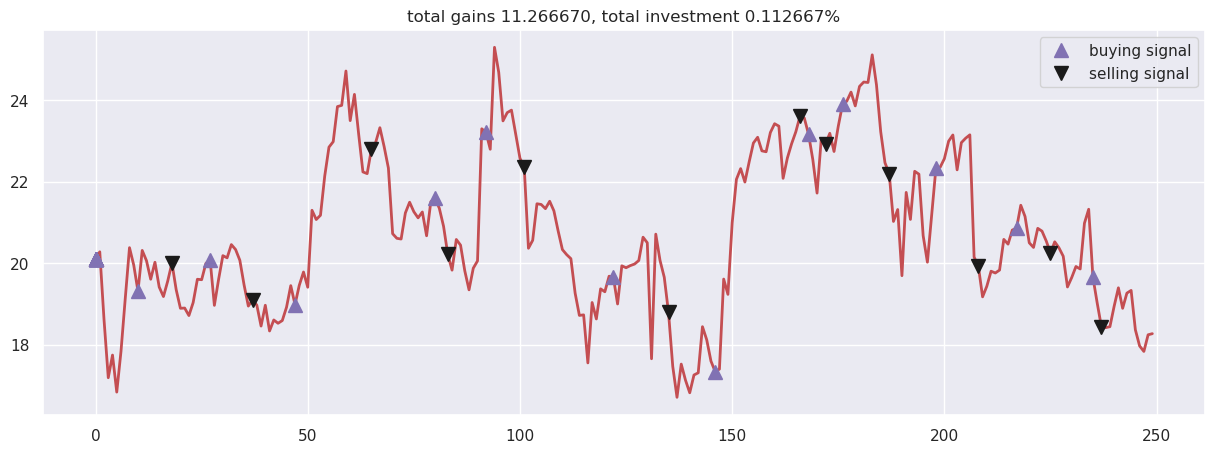

In [26]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [29]:
def monte_carlo_buy_stock(
    real_movement,
    signal,
    initial_money=10000,
    max_buy=20,
    max_sell=20,
    num_simulations=100,
    price_noise=0.02,
    signal_noise=0.1,
):
    simulation_results = []
    all_buy_states = []
    all_sell_states = []
    
    for sim in range(num_simulations):
        # Step 1: Add random noise to real movements
        noisy_real_movement = real_movement * (1 + np.random.normal(0, price_noise, len(real_movement)))
        
        # Step 2: Add randomness to the signals
        noisy_signal = signal.copy()
        for i in range(len(signal)):
            if np.random.rand() < signal_noise:
                noisy_signal[i] = -noisy_signal[i]  # Flip the signal (buy becomes sell, sell becomes buy)

        # Step 3: Simulate trading
        starting_money = initial_money
        states_buy = []
        states_sell = []
        current_inventory = 0

        def buy(i, initial_money, current_inventory):
            shares = initial_money // noisy_real_movement[i]
            if shares > 0:
                buy_units = min(shares, max_buy)
                initial_money -= buy_units * noisy_real_movement[i]
                current_inventory += buy_units
                states_buy.append(i)
            return initial_money, current_inventory

        for i in range(len(noisy_real_movement) - int(0.025 * len(real_movement))):
            state = noisy_signal[i]
            if state == 1:
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
            elif state == -1 and current_inventory > 0:
                sell_units = min(current_inventory, max_sell)
                total_sell = sell_units * noisy_real_movement[i]
                initial_money += total_sell
                current_inventory -= sell_units
                states_sell.append(i)

        # Step 4: Record results for this simulation
        total_gains = initial_money - starting_money
        investment_return = (total_gains / starting_money) * 100
        simulation_results.append((total_gains, investment_return))
        all_buy_states.append(states_buy)
        all_sell_states.append(states_sell)

    return simulation_results, all_buy_states, all_sell_states


In [30]:
# Run the Monte Carlo simulation
simulation_results, all_buy_states, all_sell_states = monte_carlo_buy_stock(
    df.Close, signals['positions'], num_simulations=100
)

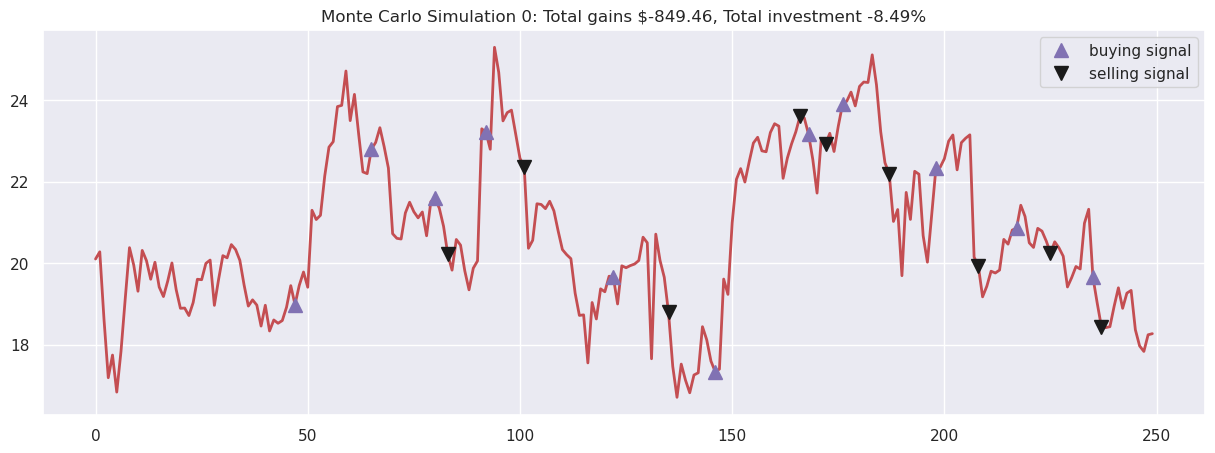

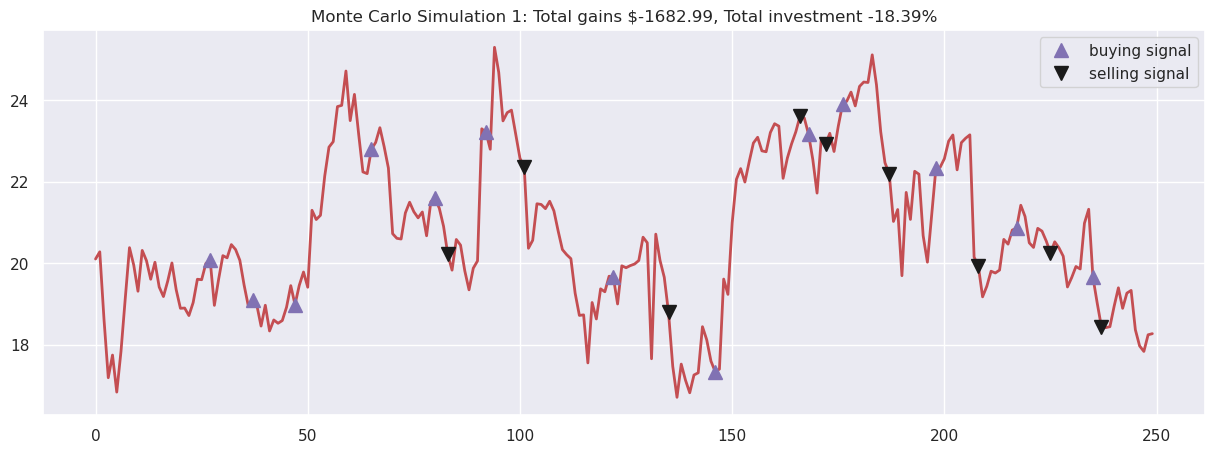

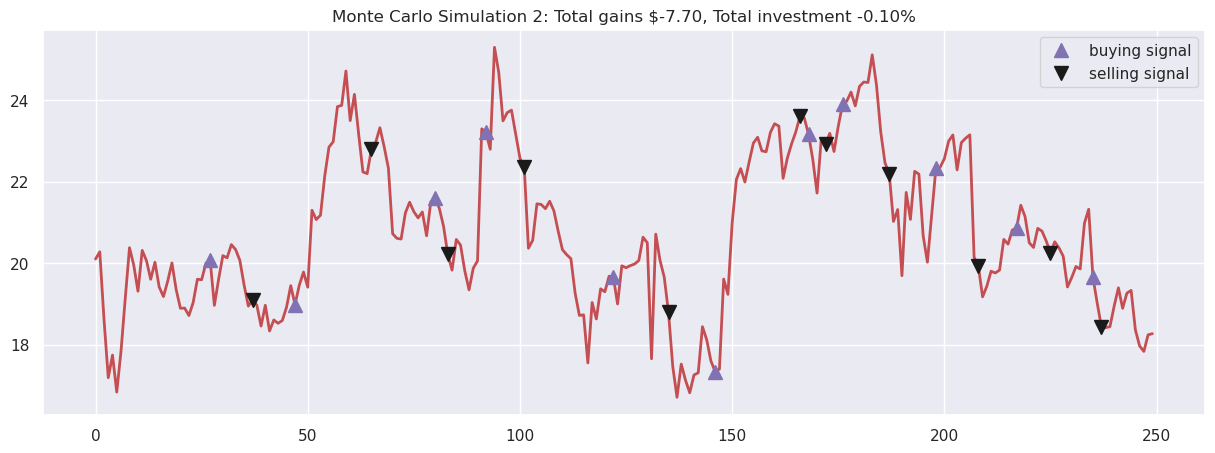

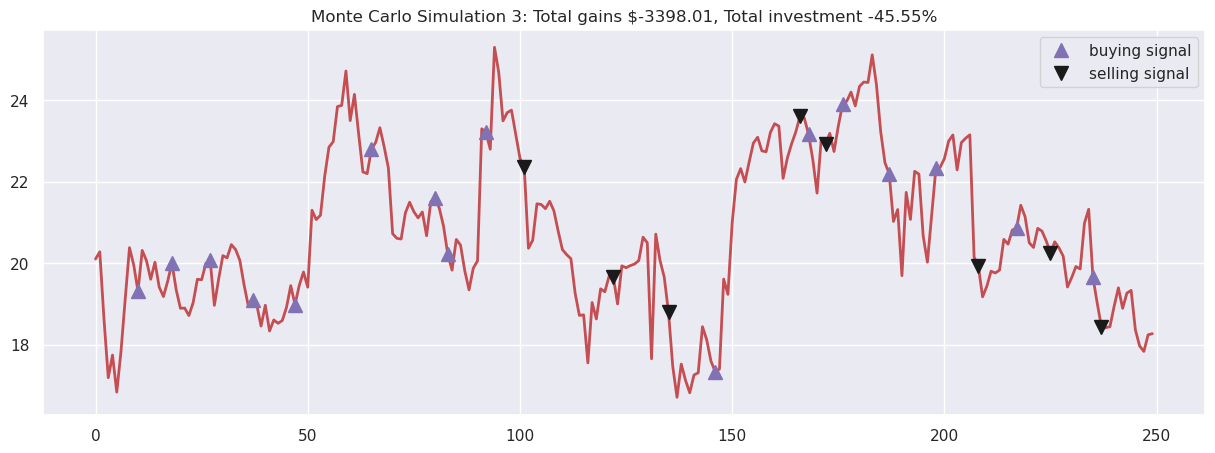

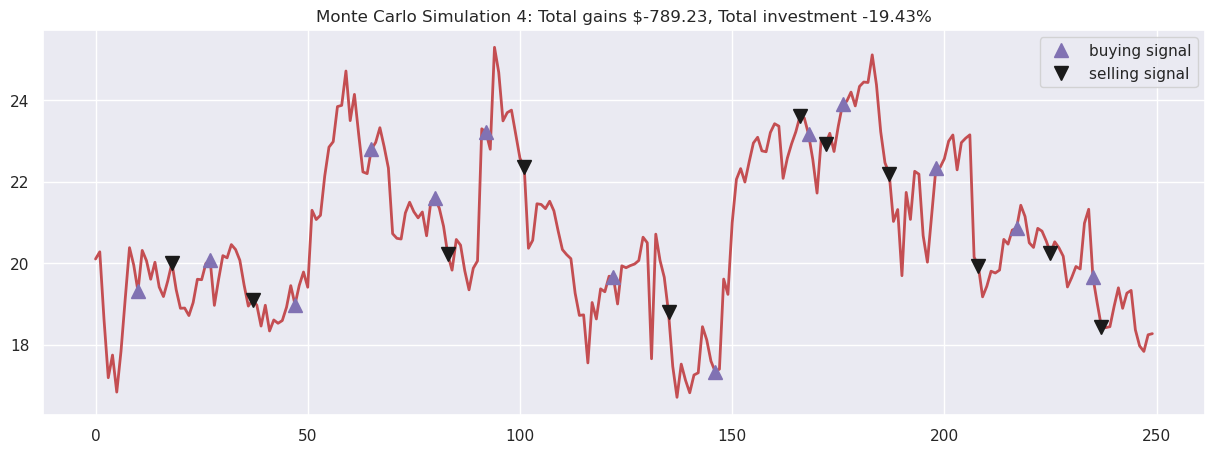

In [34]:
for i in range(5):
    chosen_sim = i  # Change this to visualize other simulations
    states_buy = all_buy_states[chosen_sim]
    states_sell = all_sell_states[chosen_sim]
    total_gains, invest = simulation_results[chosen_sim]
    # Plot the chosen simulation
    close = df['Close']
    fig = plt.figure(figsize=(15, 5))
    plt.plot(close, color='r', lw=2.)
    plt.plot(close, '^', markersize=10, color='m', label='buying signal', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='k', label='selling signal', markevery=states_sell)
    plt.title('Monte Carlo Simulation %d: Total gains $%.2f, Total investment %.2f%%' % (chosen_sim, total_gains, invest))
    plt.legend()
    plt.show()


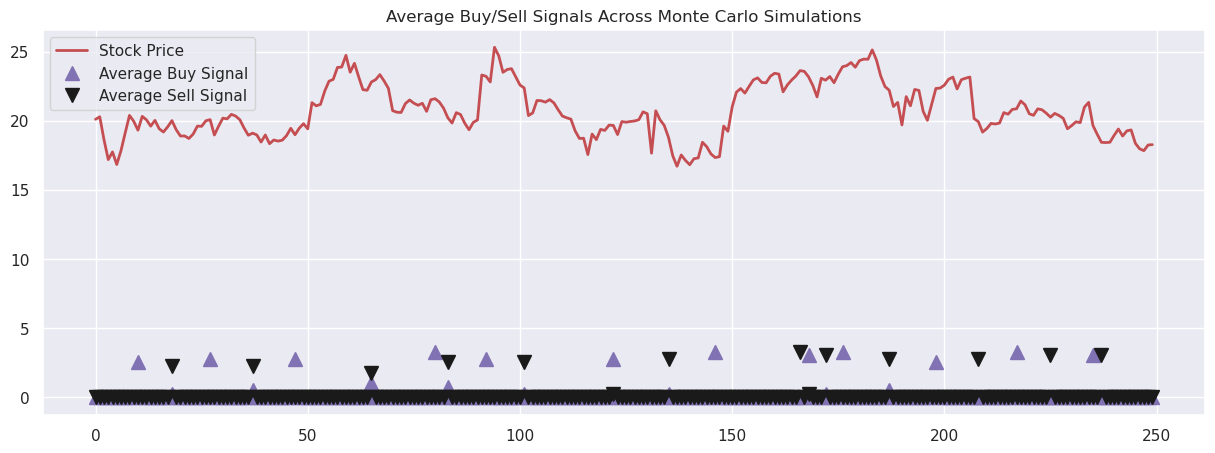

In [33]:
# Aggregate buy/sell states across simulations
all_buys = np.zeros(len(close))
all_sells = np.zeros(len(close))

for buy_states in all_buy_states:
    all_buys[buy_states] += 1
for sell_states in all_sell_states:
    all_sells[sell_states] += 1

# Normalize to show probabilities
all_buys /= len(all_buy_states)
all_sells /= len(all_sell_states)

# Plot aggregated probabilities
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2., label='Stock Price')
plt.plot(all_buys * max(close), '^', markersize=10, color='m', label='Average Buy Signal')
plt.plot(all_sells * max(close), 'v', markersize=10, color='k', label='Average Sell Signal')
plt.title('Average Buy/Sell Signals Across Monte Carlo Simulations')
plt.legend()
plt.show()
